In [74]:
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np

# Lista 10 (8 pkt.)

## Zadanie 1 (2 pkt.)

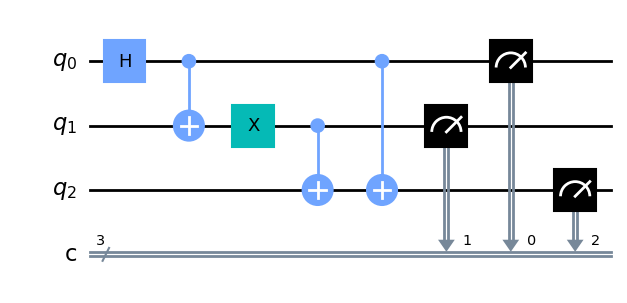

In [75]:
qc = QuantumCircuit(3,3)

qc.h(0)
qc.cx(0,1)
qc.x(1)
qc.cx(1,2)
qc.cx(0,2)

qc.measure([0,1,2],[0,1,2])

qc.draw(output='mpl',style="clifford")

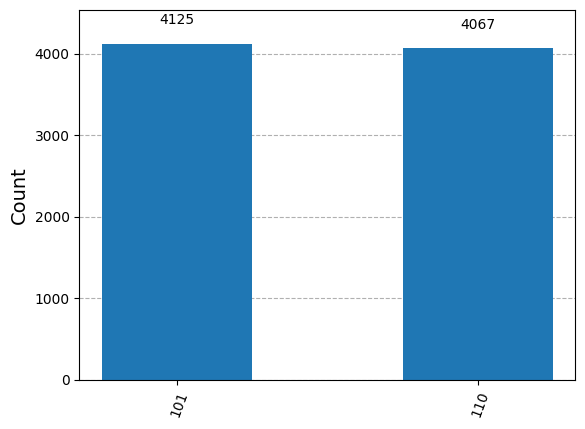

In [76]:
# Transpile for simulator
simulator = AerSimulator()
qct = transpile(qc, simulator)

# Run and get counts
result = simulator.run(qct,shots=8192).result()
counts = result.get_counts(qct)
plot_histogram(counts)


Policz ręcznie (np. na kartce) jak będzie wyglądał stan kwantowy po wykonaniu powyższego obwodu (przed pomiarem), wyznacz jakie są prawdopodobieństwa otrzymania poszczególnych wyników, tj. $|000\rangle$,$|001\rangle$, $|010\rangle$, itd., wykonaj symulację tego obwodu, narysuj histogram i sprawdź czy otrzymane prawdopodobieństwa zgadzają się z wyliczonymi. 

Uwaga: należy tu pamiętać o konwencji Qiskit-a, który zczytuje wyniki od ostaniego klasycznego rejestru. 

Uwaga: Qasm simulator przyjmuje jako paramter ilość niezależnych pomiarów obwodu (shots). W przypadku komputerów kwantowych IBM, zwykle stosuje się 1000-100000 shotów na pojedynczy obwód. Dla takich liczb pomiarów czas pracy komputera kwantowego jest w przybliżeniu proporcjonalny do liczby shotów.

Rozwiązanie:

<img src="zad1.jpeg" width="500" align="center"/>

## Zadanie 2 (2 pkt.)

To samo co poprzednio. Bramka $U$ jest zdefiniowana następująco:

$$U\left(\theta,\phi,\lambda\right)=\left(\begin{array}{cc}
\cos\frac{\theta}{2}&-e^{i\lambda}\sin\frac{\theta}{2}\\
e^{i\phi}\sin\frac{\theta}{2}&e^{i(\phi+\lambda)}\cos\frac{\theta}{2}\\
\end{array}\right)$$

Jest to najbardziej ogólna jednokubitowa bramka (unitarna).

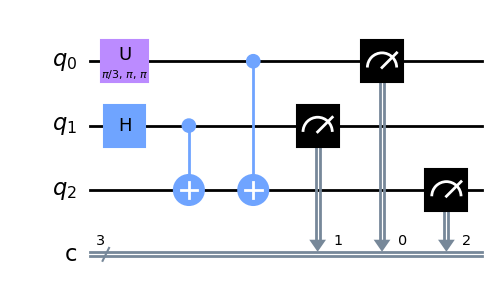

In [77]:
qc = QuantumCircuit(3,3)

qc.u(np.pi/3,np.pi,np.pi,0) #theta=pi/3,phi=pi,lambda=pi
qc.h(1)
qc.cx(1,2)
qc.cx(0,2)

qc.measure([0,1,2],[0,1,2])

qc.draw(output='mpl',style="clifford")

## Zadanie 3 (2 pkt.)

W tym zadaniu dokonamy teleportacji stanu kwantowego. Najpierw zdefiniujmy sobie jakiś stan kwantowy, np. generowany przez następującą bramkę:

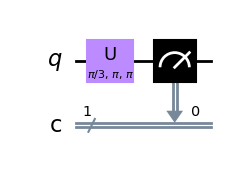

In [78]:
qc = QuantumCircuit(1,1)
qc.u(np.pi/3,np.pi,np.pi,0)
qc.measure([0],[0])
qc.draw(output='mpl',style="clifford")

Jest to następujący stan:

$$\frac{\sqrt{3}}{2}|0\rangle-\frac{1}{2}|1\rangle$$

możemy sprawdzić, że robiąc symulację dostajemy rzeczywiście prawdopodobieństwa $|\frac{\sqrt{3}}{2}|^2=\frac{3}{4}$ oraz $|-\frac{1}{2}|^2=\frac{1}{4}$

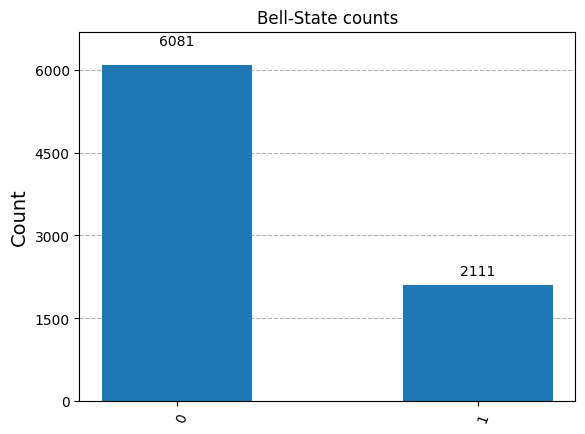

In [79]:
qc = transpile(qc, simulator)
# Run and get counts
result = simulator.run(qc,shots=8192).result()
counts = result.get_counts(qc)
plot_histogram(counts, title='Bell-State counts')

powyższy stan będziemy chcieli przeteleportować, powiedzmy między Alicją i Bobem, zdefiniujmy obwód z 3 kubitami i 3 klasycznymi bitami, tym razem wprowadzimy je za pomocą **ClassicalRegister** i **QuantumRegister**, kubit numer 0 będzie tym na którym będzie stan, który chcemy przeteleportować, będzie on w posiadaniu Alicji, kubity nr 1 i nr 2 są kubitami, która wprowadzimy w stan splątany i posłużą nam za pośrednika w teleportacji, kubit nr 1 bedzia miała Alicja a kubit nr 2 Bob.

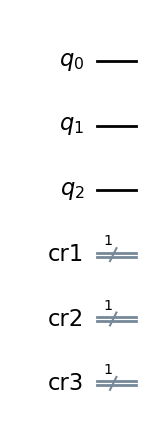

In [80]:
cr1=ClassicalRegister(1,name='cr1')
cr2=ClassicalRegister(1,name='cr2')
cr3=ClassicalRegister(1,name='cr3')

qr=QuantumRegister(3,name='q')

qc = QuantumCircuit(qr,cr1,cr2,cr3)

qc.draw(output='mpl',)

następnie dodajemy bramkę generującą stan, który chcemy przeteleportować, na koniec każdego etapu będziemy wstawiać barierę (linia przerywana obrazku) za pomocą metody **.barrier()**, powinnniśmy otrzymać:

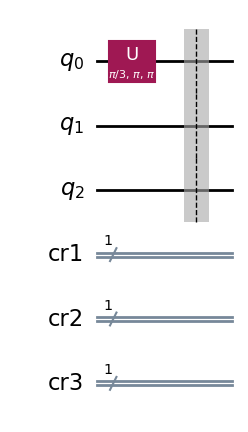

In [81]:
qc.u(np.pi/3,np.pi,np.pi,0)
qc.barrier()

qc.draw(output='mpl')

teraz tworzymy parę splątaną między kubitem numer 1 należącym do Alicji i kubitem numer 2 należącym do Boba, chcemy uzyskać parę splątaną w postaci $\frac{1}{\sqrt{2}}\left(|00\rangle+|11\rangle\right)$, wygenerujemy ją za pomocą bramki Haadamarda i CNOT-a:

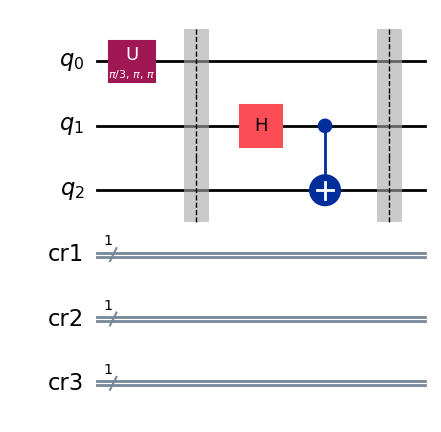

In [82]:
qc.h(1)
qc.cx(1,2)
qc.barrier()

qc.draw(output='mpl')

następnie musimy wykonać pomiar na dwóch kubitach Alicji (nr 0 i nr 1) ale w tzw. bazie Bella, jest to baza w przestrzeni dwóch kubitów skaładająca sie ze stanów: $\frac{1}{\sqrt{2}}\left(|00\rangle+|11\rangle\right)$, $\frac{1}{\sqrt{2}}\left(|00\rangle-|11\rangle\right)$, $\frac{1}{\sqrt{2}}\left(|01\rangle+|10\rangle\right)$, $\frac{1}{\sqrt{2}}\left(|01\rangle-|10\rangle\right)$, aby obrócić do bazy Bella należy użyć CNOT-a i Hadamarda.

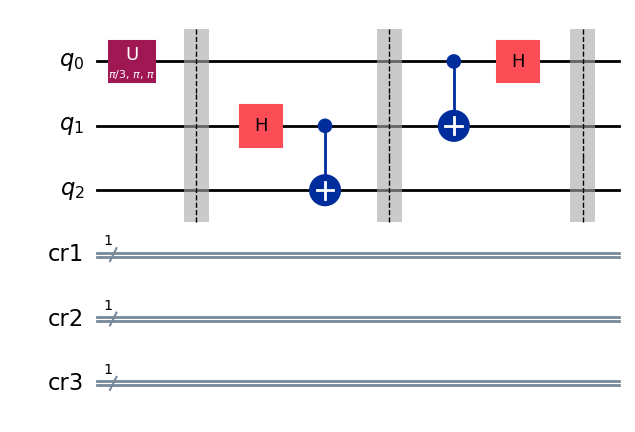

In [83]:
qc.cx(0,1)
qc.h(0)
qc.barrier()

qc.draw(output='mpl')

potem Alicja dokonuje pomiaru na swoich kubitach (nr 0 i nr 1)

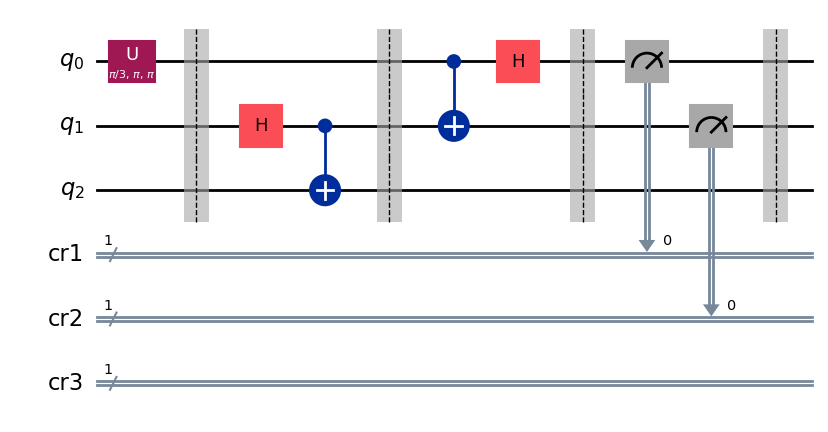

In [84]:
qc.measure([0,1], [0,1])
qc.barrier()

qc.draw(output='mpl')

następnie Alicja przesyła Bobowi otrzymany wynik, tj. albo '00' albo '01' albo '10' albo '11'. Należy tu zaznaczyć, że prawdopodobieństwo uzyskania każdego z tych wyników jest takie samo i nie zależy od stanu, który teleportujemy. Innymi słowy, nie da się, na podstawie tylko tego wyniku, nic powiedzieć na temat teleportowanego stanu. Bob stosownie do wyniku aplikuje na swoim kubicie albo nic albo bramkę $Z=\left(\begin{array}{cc}
1&0\\
0&-1\\
\end{array}\right)$ albo bramkę $X$ albo bramkę $X$ i $Z$, w celu wykonania bramki pod warunkiem określonego wyniku wcześniejszego pomiaru stosujemy metodę **.c_if(cr,1)**, która wykona daną operację pod warunkiem, że rejestr klasyczny **cr** jest równy 1, dlatego właśnie musieliśmy zdefiniować rejestry klasyczne każdy osobno, tj. **cr1**, **cr2**, **cr3**.

Np.:

**qc.x(2).c_if(cr2, 1)**

oznacza, że do obowdu **qc** zostanie dodana bramka $X$ na kubicie nr 2, która będzie wykonywana pod warunkiem, że bit **cr2** będzie równy 1.

/var/folders/kk/sxg6zhbs2t7gwnsh7xr9ygq00000gn/T/ipykernel_43934/559621767.py:1: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.x(2).c_if(cr2, 1) # X jeśli cr2 to 1
/var/folders/kk/sxg6zhbs2t7gwnsh7xr9ygq00000gn/T/ipykernel_43934/559621767.py:2: DeprecationWarning: The method ``qiskit.circuit.instructionset.InstructionSet.c_if()`` is deprecated as of qiskit 1.3.0. It will be removed in 2.0.0.
  qc.z(2).c_if(cr1, 1) # Z jeśli cr1 to 1


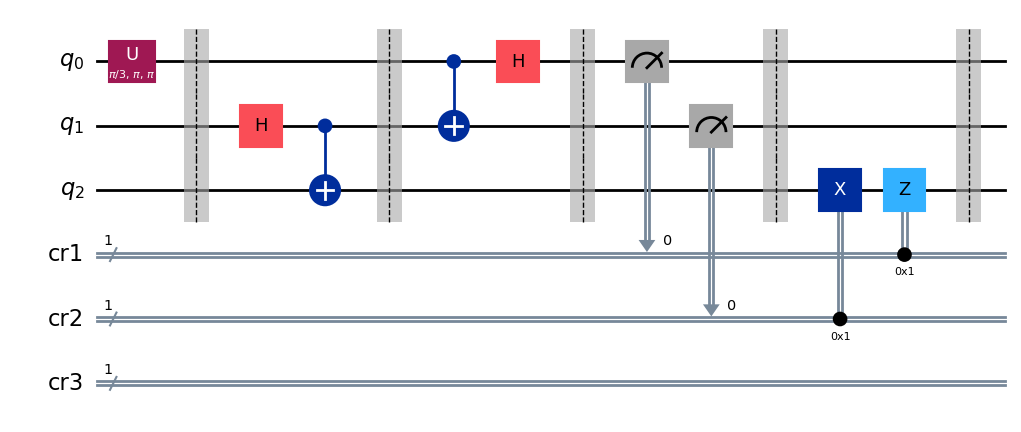

In [85]:
qc.x(2).c_if(cr2, 1) # X jeśli cr2 to 1
qc.z(2).c_if(cr1, 1) # Z jeśli cr1 to 1
qc.barrier()

qc.draw(output='mpl')

po wykonaniu odpowiedniej operacji Bob na swoim kubicie nr 2 uzyska stan taki jaki Alicja miała na początku na swoim kubcie nr 0, warto tutaj zaznaczyć, że Alicja na swoim kubicie nr 0 już nie ma tego stanu, gdyby on tam pozostał łamałoby to tzw. zakaz klonowania.

Na końcu sprawdzimy czy rzeczywiście stan otrzymany na końcu jest poprawny, dokonujemy pomiaru na ostanim kubicie.

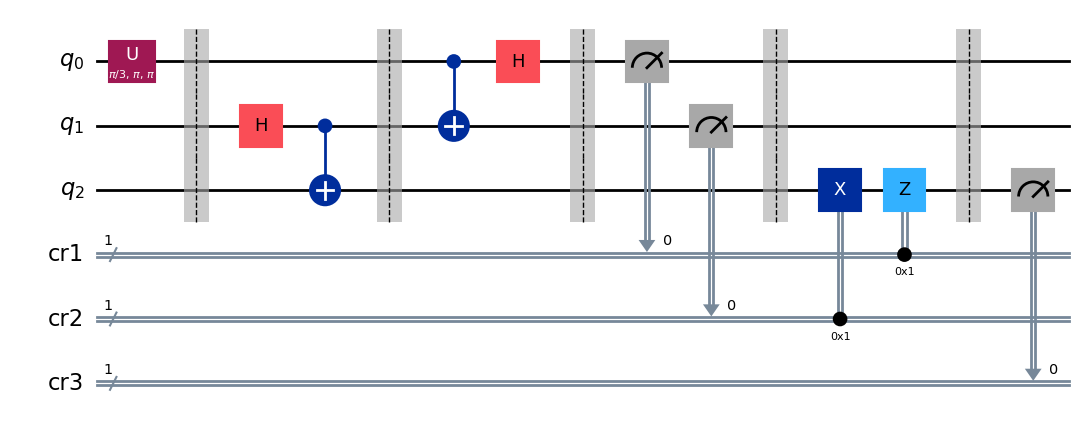

In [86]:
qc.measure([2], [2])

qc.draw(output='mpl')

robimy symulację i następnie musimy zliczyć ile razy otrzymaliśmy '0' na ostanim kubicie i ile razy '1', należy tu pamiętać o konwencji Qiskit-a, który zczytuje wyniki od ostaniego kubitu, potem rysujemy histogram, i porównujemy go z histogramem z poczatku zadania, który odpowiadał stanowi, który chcieliśmy przeteleportować.

In [87]:
#symulacja:
simulator = AerSimulator()
qct = transpile(qc, simulator)

result = simulator.run(qct,shots=8192).result()
counts = result.get_counts(qct)

counts_last = {0: 0, 1: 0}

for (k, v) in counts.items():
    if k[0] == '0':
        counts_last[0] += v
    else:
        counts_last[1] += v

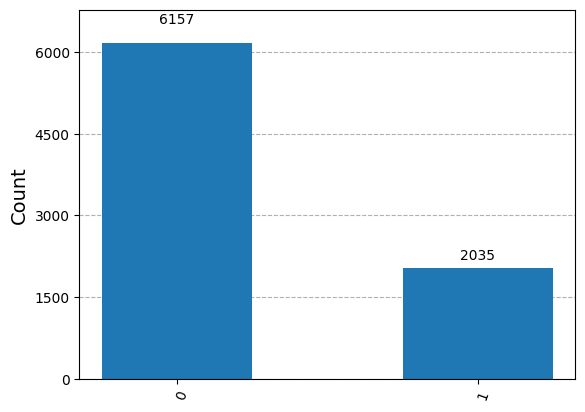

In [89]:
plot_histogram(counts_last)

Uwaga: Sprawdzenie prawdopodobieństw nie jest wystarczające do potwierdzenia, że otrzymany stan jest taki sam jak początkowy, np. stan $\frac{\sqrt{3}}{2}|0\rangle-\frac{1}{2}|1\rangle$ oraz stan $\frac{\sqrt{3}}{2}|0\rangle+\frac{1}{2}|1\rangle$ nie są sobie równe ale dają taki sam rozkład prawdopodobieństwa. Aby w pełni zbadać stan należałoby wykonać tzw. tomografię kwantową.

Uwaga: używamy tutaj metody **barrier()** tylko wyłącznie dla uzyskania bardziej przejrzystego diagramu. W rzeczywistości noie jest ona potrzebna w celu uzyskania poprawnych wyników. Kolejność wykonania operacji na rzeczywistym komputerze kwantowym jest optymalizowana przez transpiler Qiskita biorąc pod uwagę bieżącą kalibrację maszyny. 

## Zadanie 4 (2 pkt.)

Zadanie do wykonania ręcznie (np. na kartce).

Załóżmy, że stan który chcemy teleportować ma ogólną postać:

$$\alpha|0\rangle+\beta|1\rangle$$

zatem początkowy stan całego kwantowego rejestru to:

$$\alpha|000\rangle+\beta|100\rangle$$

zapisz kolejne kroki wykonywane w teleportacji do momentu pomiarów wykonywanych przez Alicję, w wyniku pomiaru stan kolapsuje losowo na jeden ze stanów bazy w której dokonujemy pomiaru, rozważ wszystkie cztery przypadki, tj. w pierwszym przypadku dostajemy w wyniku pomiaru '00' i stan na dwóch pierwszych kubitach (tych na których był pomiar) kolapsuje do $|00\rangle$, w drugim przypadku dostajemy w wyniku pomiaru '01' i stan na dwóch pierwszych kubitach (tych na których był pomiar) kolapsuje do $|01\rangle$, itd. Następnie w każdym przypadku wykonaj na kubicie Boba odpowiednią operację i zobacz, że stan który uzyska Bob to ten, który chcieliśmy przeteleportować, czyli:

$$\alpha|0\rangle+\beta|1\rangle$$